# Automatic Highlights Generator

The architecture of this model is as follows:


![alt text](https://lh6.googleusercontent.com/LPKnS8mJJOo6xfNmsw82AyZV3XsQBmeAMbpKjP0I7edy8-zhjlGn6xer9GGrIY7WLf4iopFfV4SSOtN_eGRQHhCI9J7fOUbBWhhLkyQ)

###Extraction of Audio
The input for this model is a video of any length. The video should be a cricket match video with clear audio footage. This audio timings should sync perfectly with the corresponding video. First, from the input video audio signals are extracted separately using the Moviepy package in python. 

###Compute Short Time Energy
The energy or power of an audio signal refers to the loudness of the sound. It is computed by the sum of the square of the amplitude of an audio signal in the time domain. When energy is computed for a chunk of an entire audio signal, then it is known as Short Time Energy. The audio extracted from the input is separated into chunks of specified length and short time energy is computed for each of them.

###Extract clips above Threshold
The Chunks with energy levels above a certain threshold are filtered. During our research work we spotted that most of the highlights clips (clips with higher energy level) lie more than 70percentile. With a fixed threshold the audio chunks which have greater energy levels are extracted with start and end timings. With these audio start and end timings in seconds, the video chunks with higher energy level can be extracted. 


###Concatenate Clips
The individual clips are merged together using the moviepy package in python to form a single highlight video which is the final output.



In [ ]:
#The moviepy package which is used for handling videos and audios using python is imported
import moviepy
import moviepy.editor

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2048000/45929032 bytes (4.5%)6070272/45929032 bytes (13.2%)10084352/45929032 bytes (22.0%)14188544/45929032 bytes (30.9%)18292736/45929032 bytes (39.8%)22274048/45929032 bytes (48.5%)26173440/45929032 bytes (57.0%)30228480/45929032 bytes (65.8%)34332672/45929032 bytes (74.8%)38486016/45929032 bytes (83.8%)42729472/45929032 bytes (93.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
#The Google Drive is mounted
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#The match is given as input it may be a any sporting video (cricket/football/handball etc..)
video = moviepy.editor.VideoFileClip('/content/gdrive/My Drive/mm.mp4')

In [ ]:
audio = video.audio

In [ ]:
#The audio from the input video is exracted and save as a seperate mp3 file in given path
audio.write_audiofile("/content/gdrive/My Drive/Speechmethod/football.mp3")

[MoviePy] Writing audio in /content/gdrive/My Drive/Speechmethod/football.mp3


100%|██████████| 128217/128217 [03:18<00:00, 645.87it/s]

[MoviePy] Done.


In [ ]:
#The audio file is imported using LibROSA
filename='/content/gdrive/My Drive/Speechmethod/football.mp3' 
import librosa 
x, sr = librosa.load(filename,sr=16000)

In [ ]:
int(librosa.get_duration(x, sr)/60)

96

In [ ]:
#The input audio signal is separted into chunks of window_size 5sec
max_slice=5
window_length = max_slice * sr

In [ ]:
#An example of a single chunk
import IPython.display as ipd 
a=x[21*window_length:22*window_length] 
ipd.Audio(a, rate=sr)

The Short time enegy can computed by the sum of the square of the amplitude of an audio signal in the time domain

In [ ]:
energy = sum(abs(a**2))
print(energy)

30.910934998734614


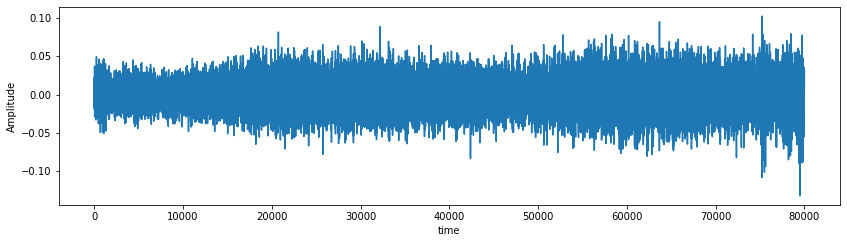

In [ ]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(14, 8)) 
ax1 = fig.add_subplot(211) 
ax1.set_xlabel('time') 
ax1.set_ylabel('Amplitude') 
ax1.plot(a)

The Energy Level is computed for each chunk and a Histogram is plotted

In [ ]:
import numpy as np
energy = np.array([sum(abs(x[i:i+window_length]**2)) for i in range(0, len(x), window_length)])
print(energy)

[47.9053227  33.73345207 29.98697637 ... 32.89632846 39.24452533
 48.07962501]


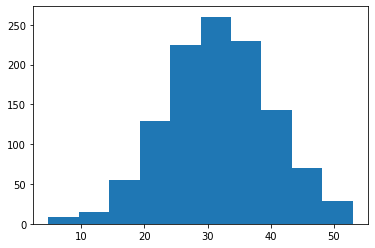

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(energy) 
plt.show()

A Threshold is fixed based on Histogram plotted above. This Threshold is set in a intution that Highlight clips would have high energy levels.

Those clips having energy levels above the Threshold are filtered and saved in a dataframe along with their Start time , End time

In [ ]:
import pandas as pd
df=pd.DataFrame(columns=['energy','start','end'])
thresh= 42.5
row_index=0
for i in range(len(energy)):
  value=energy[i]
  if(value>=thresh):
    i=np.where(energy == value)[0]
    df.loc[row_index,'energy']=value
    df.loc[row_index,'start']=i[0] * 5
    df.loc[row_index,'end']=(i[0]+1) * 5
    row_index= row_index + 1
 

In [ ]:
df

,energy,start,end
0,47.9053,0,5
1,43.5949,15,20
2,45.9919,20,25
3,42.5242,30,35
4,43.0887,45,50
...,...,...,...
104,44.4119,5760,5765
105,49.3082,5765,5770
106,49.7245,5775,5780
107,46.0014,5785,5790


Now consecutive clips are identified and merged together

In [ ]:
temp=[]
i=0
j=0
n=len(df) - 2
m=len(df) - 1
while(i<=n):
  j=i+1
  while(j<=m):
    if(df['end'][i] == df['start'][j]):
      df.loc[i,'end'] = df.loc[j,'end']
      temp.append(j)
      j=j+1
    else:
      i=j
      break  
df.drop(temp,axis=0,inplace=True)


In [ ]:
df

,energy,start,end
0,47.9053,0,5
1,43.5949,15,25
3,42.5242,30,35
4,43.0887,45,50
5,44.9928,140,145
...,...,...,...
101,45.5264,5725,5730
102,49.1024,5750,5770
106,49.7245,5775,5780
107,46.0014,5785,5790


Now the actual Input Video is taken and with Dataframe containing Start time and End time , the appropriate clips are extracted and saved seperately.

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import moviepy.editor as mp
from moviepy.editor import VideoFileClip, concatenate_videoclips
#input video
my_clip = mp.VideoFileClip('/content/gdrive/My Drive/mm.mp4')
#duration of input video
print("Duration of video : ", my_clip.duration)
# An empty list is intialized to store the video clips
vi = []
start=np.array(df['start'])
end=np.array(df['end'])
for i in range(len(df)):
 if(i!=0):
  start_lim = start[i] - 5 #start_lim is subtracted 5sec from its actual timing in order to not miss its cause (Eg. Bowler delivering the ball before the batsmen is out)
 else:
  start_lim = start[i] # End lim is also extended by 2sec
 end_lim   = end[i]-2
 #The video clips extracted are appended in a list
 vi.append(my_clip.subclip(start_lim,end_lim))



Duration of video :  5814.81


In [ ]:
# The list containing seperate video clips are merged together to form a Single Highlight video
concat_clip = mp.concatenate_videoclips(vi)
concat_clip.write_videofile("/content/gdrive/My Drive/Speechmethod/h42.mp4")

[MoviePy] >>>> Building video /content/gdrive/My Drive/Speechmethod/h42.mp4
[MoviePy] Writing audio in h42TEMP_MPY_wvf_snd.mp3


100%|██████████| 16472/16472 [00:38<00:00, 425.49it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/gdrive/My Drive/Speechmethod/h42.mp4



100%|█████████▉| 18675/18676 [10:41<00:00, 29.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/Speechmethod/h42.mp4 

